In [34]:
# For all examples in this section we use the following imports.
# Note that we are using torch_geometric's DataLoader.
import torch
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from torch.utils.data import random_split

def train(wd, size, init_scale):
    #wd = 0.
    #size = 100 #int(params[0]/2)*2
    #init_scale = 3 #params[1]
    seed = 0
    np.random.seed(seed)
    torch.manual_seed(seed)
    alpha = init_scale
    # let's load the QM9 small molecule dataset
    dset = QM9('.')
    #size = 1000
    epochs = int(100*50000/size)
    dset = dset[:size]
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    class ExampleNet(torch.nn.Module):
        def __init__(self, num_node_features, num_edge_features):
            super().__init__()
            conv1_net = nn.Sequential(
                nn.Linear(num_edge_features, 32),
                nn.ReLU(),
                nn.Linear(32, num_node_features*32))
            conv2_net = nn.Sequential(
                nn.Linear(num_edge_features, 32),
                nn.ReLU(),
                nn.Linear(32, 32*16))
            self.conv1 = NNConv(num_node_features, 32, conv1_net)
            self.conv2 = NNConv(32,16, conv2_net)
            self.fc_1 = nn.Linear(16, 32)
            self.out = nn.Linear(32, 1)
        def forward(self, data):
            batch, x, edge_index, edge_attr = (
                data.batch, data.x, data.edge_index, data.edge_attr)
            # First graph conv layer
            x = F.relu(self.conv1(x, edge_index, edge_attr))
            # Second graph conv layer
            x = F.relu(self.conv2(x, edge_index, edge_attr))
            x = global_add_pool(x,batch)
            x = F.relu(self.fc_1(x))
            output = self.out(x)
            return output
        
        
    def L2(model):
        L2_ = 0.
        for p in model.parameters():
            L2_ += torch.sum(p**2)
        return L2_

    def rescale(model, alpha):
        for p in model.parameters():
            p.data = alpha * p.data
            
    batch_size = 32
    
    train_set, test_set = random_split(dset,[int(size/2), int(size/2)])
    trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

    
    # initialize a network
    qm9_node_feats, qm9_edge_feats = 11, 4
    net = ExampleNet(qm9_node_feats, qm9_edge_feats)
    # initialize an optimizer with some reasonable parameters
    optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, weight_decay = wd)
    target_idx = 1 # index position of the polarizability label
    net.to(device)
    
    rescale(net, alpha)
    L2_ = L2(net)
    
    train_best = 1e10
    test_best = 1e10
    
    train_losses = []
    test_losses = []
    
    for total_epochs in range(epochs):
        epoch_loss = 0
        total_graphs_train = 0
        test_loss = 0
        total_graphs_test = 0
        
        for batch in trainloader:
            net.train()
            batch.to(device)
            optimizer.zero_grad()
            output = net(batch)
            loss = F.mse_loss(
            output,batch.y[:, target_idx].unsqueeze(1))
            loss.backward()
            epoch_loss += loss.item()
            total_graphs_train += batch.num_graphs
            optimizer.step()
            
            train_losses.append(loss.item()/batch.num_graphs)
            #L2_new = L2(net)
            #rescale(net, torch.sqrt(L2_/L2_new))
            net.eval()
            batch = next(iter(testloader))
            batch.to(device)
            output = net(batch)
            loss = F.mse_loss(
            output,batch.y[:, target_idx].unsqueeze(1))
            test_loss += loss.item()
            total_graphs_test += batch.num_graphs
            
            test_losses.append(loss.item()/batch.num_graphs)
            
        train_avg_loss = epoch_loss / total_graphs_train
        if train_avg_loss < train_best:
            train_best = train_avg_loss
        
        test_avg_loss = test_loss / total_graphs_test
        #test_losses.append(test_avg_loss)
        if test_avg_loss < test_best:
            test_best = test_avg_loss
        print(f"Epochs: {total_epochs} | "
           f"epoch avg. loss: {train_avg_loss:.3f} | "
           f"test avg. loss: {test_avg_loss:.3f}")

    np.savetxt("./results/train_size_%d_alpha_%.4f"%(size, init_scale), np.array([train_best]))
    np.savetxt("./results/test_size_%d_alpha_%.4f"%(size, init_scale), np.array([test_best]))
    return epochs, train_losses, test_losses


In [ ]:
epochs, train_losses, test_losses = train(wd = 0.00, size = 100, init_scale = 1.0)

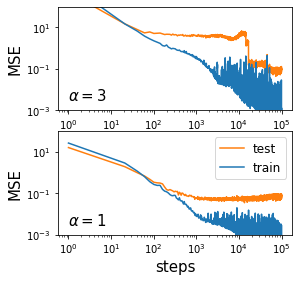

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(4.2,4.2))

plt.subplot(2,1,2)

train_losses = np.loadtxt("./grok_results/train_size_100_scale_1_wd_0.0")
test_losses = np.loadtxt("./grok_results/test_size_100_scale_1_wd_0.0")

plt.plot((np.arange(len(test_losses))+1)[::20], np.mean(np.array(test_losses).reshape(-1,20), axis=1), color='#ff7f0e')
plt.plot((np.arange(len(train_losses))+1)[::20], np.mean(np.array(train_losses).reshape(-1,20), axis=1), color='#1f77b4')
#plt.xscale('log')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(1,1e4)
plt.ylim(1e-4,100)
#plt.ylim(0.,10)

plt.xlabel("steps", fontsize=15)
plt.ylabel("MSE", fontsize=15)
plt.legend(["test","train"], fontsize=12)
plt.text(1,0.003,r"$\alpha=1$", fontsize=15)
plt.ylim(1e-3,1e2)

plt.subplot(2,1,1)

train_losses = np.loadtxt("./grok_results/train_size_100_scale_3_wd_0.0")
test_losses = np.loadtxt("./grok_results/test_size_100_scale_3_wd_0.0")

plt.plot((np.arange(len(test_losses))+1)[::20], np.mean(np.array(test_losses).reshape(-1,20), axis=1), color='#ff7f0e')
plt.plot((np.arange(len(train_losses))+1)[::20], np.mean(np.array(train_losses).reshape(-1,20), axis=1), color='#1f77b4')
#plt.xscale('log')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(1,1e4)
plt.ylim(1e-2,100)
#plt.ylim(0.,10)

#plt.xlabel("steps", fontsize=15)
plt.ylabel("MSE", fontsize=15)
#plt.legend(["training", "testing"], fontsize=15)
plt.text(1,0.003,r"$\alpha=3$", fontsize=15)
plt.ylim(1e-3,1e2)

plt.savefig("./qm9_grok.pdf", bbox_inches="tight")